# Descriptive Notebook

_Yulin Zhao, Chunyu Liu_

## Summary

The purpose of this project is to conduct research on the paper entitled "Learning of Cluster-based Feature Importance for Electronic Health Record Time-series" [1]. This paper introduces a novel approach to learning cluster-based feature importance for electronic health record (EHR) time-series data. The authors present the model CAMELOT, which combines time-series K-means with the encoder-decoder network. 

We reproduced the model from scratch, replicated the experiments on MIMIC-IV-ED [2], test our hypotheses, and document our findings. Our experiment results show the consistency with the CAMELOT performance mentioned in the paper, and our proposed ablation studies seem to have little improvement from the original architecture.

In [20]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import roc_auc_score, f1_score, recall_score

metrics = ['AUC', 'F1 score', 'Recall', 'NMI']
seeds = [1001, 1012, 1134, 2475, 6138, 7415, 1663, 7205, 9253, 1782]

SEED = 1001
torch.random.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

The MIMIC-IV-ED [2] dataset, which can be accessed from [PhysioNet](https://physionet.org/content/mimic-iv-ed/1.0/). Please be aware that we also need the core directory from the MIMIC-IV [3] dataset, which can be accessed from [PhysioNet](https://physionet.org/content/mimiciv/1.0/).

We used the same preprecossing pipeline in the paper ([code](https://github.com/hrna-ox/camelot-icml/tree/main/src/data_processing/MIMIC)). 

In [21]:
MIMIC_PARSE_TIME_VARS = ["intime", "outtime", "chartmax"]
MIMIC_PARSE_TD_VARS = [
    "sampled_time_to_end(1H)", "time_to_end", "time_to_end_min", "time_to_end_max"]
MIMIC_VITALS = ["TEMP", "HR", "RR", "SPO2", "SBP", "DBP"]
MIMIC_STATIC = ["age", "gender", "ESI"]
MIMIC_OUTCOME_NAMES = ["De", "I", "W", "Di"]

# Identifiers for main ids.
MAIN_ID_LIST = ["subject_id", "hadm_id", "stay_id", "patient_id", "pat_id"]

In [22]:
def convert_to_timedelta(df: pd.DataFrame, *args) -> pd.DataFrame:
    """Convert all given cols of dataframe to timedelta."""
    output = df.copy()
    for arg in args:
        output[arg] = pd.to_timedelta(df.loc[:, arg])

    return output


class CustomDataset(Dataset):

    def __init__(self, data_name="MIMIC", target_window=12, feat_set='vit-sta', time_range=(0, 6), parameters=None):
        if parameters is None:
            self.data_name = data_name
            self.target_window = target_window
            self.feat_set = feat_set
            self.time_range = time_range
            self.id_col = None
            self.time_col = None
            self.needs_time_to_end_computation = False
            self.min = None
            self.max = None

            # Load & process data
            self.id_col, self.time_col, self.needs_time_to_end_computation = self.get_ids(
                self.data_name)
            self.x, self.y, self.mask, self.pat_time_ids, self.features, self.outcomes, self.x_subset, self.y_data = self.load_transform()
        else:
            self.x, self.y, self.mask, self.pat_time_ids, self.features, self.outcomes, self.x_subset, self.y_data, self.id_col, self.time_col, self.needs_time_to_end_computation, self.data_name, self.feat_set, self.time_range, self.target_window, self.min, self.max = parameters

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx, :, :]
        y = self.y[idx, :]
        mask = self.mask[idx, :, :]
        pat_time_ids = self.pat_time_ids[idx, :, :]
        features = self.features
        outcomes = self.outcomes
        x_subset = self.x_subset[idx, :]
        y_data = self.y_data[idx, :]
        id_col = self.id_col
        time_col = self.time_col
        needs_time_to_end_computation = self.needs_time_to_end_computation
        data_name = self.data_name
        feat_set = self.feat_set
        time_range = self.time_range
        target_window = self.target_window
        min = self.min
        max = self.max
        return x, y, mask, pat_time_ids, features, outcomes, x_subset, y_data, id_col, time_col, needs_time_to_end_computation, data_name, feat_set, time_range, target_window, min, max

    def get_subset(self, idx):
        return CustomDataset(parameters=self[idx])

    def load_transform(self):
        # Load data
        data = self._load(self.data_name, window=self.target_window)
        self.id_col, self.time_col, self.needs_time_to_end_computation = self.get_ids(
            self.data_name)
        # print(data[0].shape, '0')
        x_inter = self._add_time_to_end(data[0])
        # print(x_inter.shape, '1')
        x_inter = self._truncate(x_inter)
        # print(x_inter.shape, '2')
        self._check_time_conversion(x_inter)

        # print(x_inter.shape, '3')
        x_subset, features = self._subset_to_features(x_inter)

        # print(x_inter.shape, '4')
        x_inter, pat_time_ids = self._convert_to_3d_arr(x_subset)
        x_subset = x_subset.to_numpy().astype(np.float32)

        # print(x_inter.shape, '5')
        x_inter = self._normalize(x_inter)

        # print(x_inter.shape, '6')
        x_out, mask = self._impute(x_inter)
        # print(x_out.shape, '7')

        outcomes = self._get_outcomes(self.data_name)
        y_data = data[1][outcomes]
        y_out = y_data.to_numpy().astype("float32")
        y_data = y_data.to_numpy().astype("float32")

        self._check_input_format(x_out, y_out)

        return x_out, y_out, mask, pat_time_ids, features, outcomes, x_subset, y_data

    def _load(self, data_name, window=4):

        data_fd = './data/MIMIC/processed/'
        # for Kaggle:
        # data_fd = f"/kaggle/input/mimic-processed/"
        try:
            os.path.exists(data_fd)
        except AssertionError:
            print(data_fd)

        if "MIMIC" in data_name:

            X = pd.read_csv(data_fd + "vitals_process.csv",
                            parse_dates=MIMIC_PARSE_TIME_VARS, header=0, index_col=0)
            y = pd.read_csv(
                data_fd + f"outcomes_{window}h_process.csv", index_col=0)
            # for Kaggle:
            # X = pd.read_csv("vitals_process.csv", parse_dates=MIMIC_PARSE_TIME_VARS, header=0, index_col=0)
            # y = pd.read_csv(f"outcomes_{window}h_process.csv", index_col=0)

            X = convert_to_timedelta(X, *MIMIC_PARSE_TD_VARS)

        else:
            raise ValueError(
                f"No available datasets. Input Folder provided {data_fd}")
        return X, y

    def get_ids(self, data_name):

        if "MIMIC" in data_name:
            id_col, time_col, needs_time_to_end = "hadm_id", "sampled_time_to_end(1H)", False

        else:
            raise ValueError(
                f"No available datasets. Input Folder provided {data_name}")

        return id_col, time_col, needs_time_to_end

    def _impute(self, X):
        s1 = self._numpy_forward_fill(X)
        s2 = self._numpy_backward_fill(s1)
        s3 = self._median_fill(s2)
        mask = np.isnan(X)
        return s3, mask

    def _convert_datetime_to_hour(self, series):
        return series.dt.total_seconds() / 3600

    def _get_features(self, key, data_name="MIMIC"):
        if isinstance(key, list):
            return key

        elif isinstance(key, str):
            if data_name == "MIMIC":
                vitals = MIMIC_VITALS
                static = MIMIC_STATIC
                vars1, vars2 = None, None

            else:
                raise ValueError(
                    f"No available datasets. Input provided {data_name}")

            features = set([])
            if "vit" in key.lower():
                features.update(vitals)

            if "vars1" in key.lower():
                features.update(vars1)

            if "vars2" in key.lower():
                features.update(vars2)

            if "lab" in key.lower():
                features.update(vars1)
                features.update(vars2)

            if "sta" in key.lower():
                features.update(static)

            if "all" in key.lower():
                features = self._get_features("vit-lab-sta", data_name)

            sorted_features = sorted(features)
            print(
                f"\n{data_name} data has been subsettted to the following features: \n {sorted_features}.")

            return sorted_features

        else:
            raise TypeError(
                f"Argument key must be one of type str or list, type {type(key)} was given.")

    def _numpy_forward_fill(self, array):
        arr_mask = np.isnan(array)
        arr_out = np.copy(array)
        arr_inter = np.where(~ arr_mask, np.arange(
            arr_mask.shape[1]).reshape(1, -1, 1), 0)
        np.maximum.accumulate(arr_inter, axis=1,
                              out=arr_inter)
        arr_out = arr_out[np.arange(arr_out.shape[0])[:, None, None],
                          arr_inter,
                          np.arange(arr_out.shape[-1])[None, None, :]]

        return arr_out

    def _numpy_backward_fill(self, array):
        arr_mask = np.isnan(array)
        arr_out = np.copy(array)

        arr_inter = np.where(~ arr_mask, np.arange(
            arr_mask.shape[1]).reshape(1, -1, 1), arr_mask.shape[1] - 1)
        arr_inter = np.minimum.accumulate(
            arr_inter[:, ::-1], axis=1)[:, ::-1]
        arr_out = arr_out[np.arange(arr_out.shape[0])[:, None, None],
                          arr_inter,
                          np.arange(arr_out.shape[-1])[None, None, :]]

        return arr_out

    def _median_fill(self, array):
        arr_mask = np.isnan(array)
        arr_out = np.copy(array)
        array_med = np.nanmedian(np.nanmedian(
            array, axis=0, keepdims=True), axis=1, keepdims=True)
        arr_out = np.where(arr_mask, array_med, arr_out)

        return arr_out

    def _get_outcomes(self, data_name):
        if data_name == "MIMIC":
            return MIMIC_OUTCOME_NAMES

    def _check_input_format(self, X, y):
        try:
            assert X.shape[0] == y.shape[0]
            assert len(X.shape) == 3
            assert len(y.shape) == 2
            assert np.sum(np.isnan(X)) + np.sum(np.isnan(y)) == 0
            assert np.all(np.sum(y, axis=1) == 1)

        except Exception as e:
            print(e)
            raise AssertionError("Input format error.")

    def _add_time_to_end(self, X):
        x_inter = X.copy(deep=True)
        if self.needs_time_to_end_computation:
            times = X.groupby(self.id_col).apply(
                lambda x: x.loc[:, self.time_col].max() - x.loc[:, self.time_col])
            x_inter["time_to_end"] = self._convert_datetime_to_hour(
                times).values

        else:
            x_inter["time_to_end"] = x_inter[self.time_col].values
            x_inter["time_to_end"] = self._convert_datetime_to_hour(
                x_inter.loc[:, "time_to_end"])

        self.time_col = "time_to_end"
        x_out = x_inter.sort_values(
            by=[self.id_col, "time_to_end"], ascending=[True, False])

        return x_out

    def _truncate(self, X):
        try:
            min_time, max_time = self.time_range
            # print(self.time_range)
            return X[X['time_to_end'].between(min_time, max_time, inclusive="left")]

        except Exception:
            raise ValueError(
                f"Could not truncate.")

    def _check_time_conversion(self, X):
        min_time, max_time = self.time_range

        assert X[self.id_col].is_monotonic_increasing is True
        assert X.groupby(self.id_col).apply(
            lambda x: x["time_to_end"].is_monotonic_decreasing).all() == True
        assert X["time_to_end"].between(
            min_time, max_time, inclusive='left').all() == True

    def _subset_to_features(self, X):
        features = [self.id_col, "time_to_end"] + \
            self._get_features(self.feat_set, self.data_name)

        return X[features], features

    def _convert_to_3d_arr(self, X):
        max_time = X.groupby(self.id_col).count()["time_to_end"].max()
        num_ids = X[self.id_col].nunique()
        feats = [col for col in X.columns if col not in [
            self.id_col, "time_to_end"]]
        id_list = X[self.id_col].unique()

        array_out = np.empty(shape=(num_ids, max_time, len(feats)))
        array_out[:] = np.nan
        array_id_times = np.empty(shape=(num_ids, max_time, 2))
        array_id_times[:, :, 0] = np.repeat(np.expand_dims(
            id_list, axis=-1), repeats=max_time, axis=-1)

        for id_ in tqdm(id_list):
            index_ = np.where(id_list == id_)[0]
            x_id = X[X[self.id_col] == id_]

            x_id_copy = x_id.copy()
            x_id_copy["time_to_end"] = - x_id["time_to_end"].diff().values

            array_out[index_, :x_id_copy.shape[0], :] = x_id_copy[feats].values
            array_id_times[index_, :x_id_copy.shape[0],
                           1] = x_id["time_to_end"].values

        return array_out.astype("float32"), array_id_times.astype("float32")

    def _normalize(self, X):
        self.min = np.nanmin(X, axis=0, keepdims=True)
        self.max = np.nanmax(X, axis=0, keepdims=True)
        return np.divide(X - self.min, self.max - self.min)

#### Dataset stats:

In [23]:
dataset = CustomDataset(time_range=(0, 10))


MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


100%|██████████| 7701/7701 [00:08<00:00, 929.04it/s]


In [24]:
ratio = np.unique(np.argmax(dataset.y, axis=1), return_counts=True)[1] / len(dataset)

print('The class ratio: ', [f'{100*i:.2f}%' for i in ratio])

The class ratio:  ['0.65%', '21.15%', '76.28%', '1.92%']


In [25]:
print('Feature shapes: ', dataset.x.shape)

print('Label shapes: ', dataset.y.shape)

Feature shapes:  (7701, 10, 9)
Label shapes:  (7701, 4)


## Data Loader

Splitting: 36% training, 24% evaluation, 40% test.

In [26]:
# Custom Dataloader
def collate_fn(data):
    x, y, mask, pat_time_ids, features, outcomes, x_subset, y_data, id_col, time_col, needs_time_to_end_computation, data_name, feat_set, time_range, target_window, min, max = zip(
        *data)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_config = {"data_name": data_name, "feat_set": feat_set,
                   "time_range (h)": time_range, "target_window": target_window}
    data_properties = {"feats": features, "id_col": id_col, "time_col": time_col,
                       "norm_min": min, "norm_max": max, "outc_names": outcomes}

    x = torch.tensor(np.array(x))
    y = torch.tensor(np.array(y))
    x = x.to(device)
    y = y.to(device)

    return x, y


def load_data(train_dataset, val_dataset, test_dataset):

    batch_size = 64
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader

In [27]:
# Stratified Sampling for train and val
train_idx, test_idx = train_test_split(np.arange(len(dataset)),
                                        test_size=0.4,
                                        random_state=SEED,
                                        shuffle=True,
                                        stratify=np.argmax(dataset.y, axis=-1))

# Subset dataset for train and val
train_val_dataset = dataset.get_subset(train_idx)
test_dataset = dataset.get_subset(test_idx)

train_idx, val_idx = train_test_split(np.arange(len(train_val_dataset)),
                                        test_size=0.4,
                                        random_state=SEED,
                                        shuffle=True,
                                        stratify=np.argmax(train_val_dataset.y, axis=-1))

train_dataset = train_val_dataset.get_subset(train_idx)
val_dataset = train_val_dataset.get_subset(val_idx)

train_loader, val_loader, test_loader = load_data(
    train_dataset, val_dataset, test_dataset)

## Model

model architecture: 

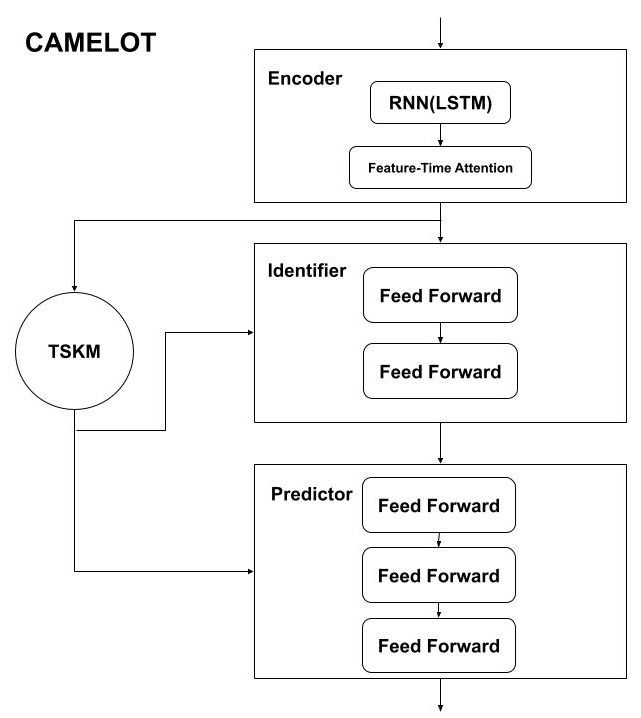

The architecture of CAMELOT is composed of the encoder, identifier, predictor, and the clustering algorithm. The encoder has several LSTM layers and a custom attention layer called FeatTimeAttention. The identifier and Predictor are both MLPs with feed-forward layers, Sigmoid activation layers, and dropout layers. The clustering algorithm is the time-series K-Means model [4].

The encoder is used to learn the latent representations. Based on the latent representations, the identifier computes the cluster assignment probabilities. The predictor then computes the prediction based on the aggregated latent representations based on the cluster probabilities. 

#### Attention, Encoder, Identifier, Predictor:

In [30]:
class FeatTimeAttention(nn.Module):
    def __init__(self, latent_dim, input_shape):
        super().__init__()

        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')

        self.latent_dim = latent_dim
        T, D_f = input_shape
        # Define Kernel and Bias for Feature Projection
        self.kernel = torch.zeros(
            (1, 1, D_f, self.latent_dim), requires_grad=True).to(self.device)
        nn.init.xavier_uniform_(self.kernel)
        self.bias = torch.zeros(
            (1, 1, D_f, self.latent_dim), requires_grad=True).to(self.device)
        nn.init.uniform_(self.bias)

        # Define Time aggregation weights for averaging over time.
        self.unnorm_beta = torch.zeros((1, T, 1), requires_grad=True)
        nn.init.uniform_(self.unnorm_beta)

    def forward(self, x, latent):
        o_hat, _ = self.generate_latent_approx(x, latent)
        weights = self.calc_weights(self.unnorm_beta)
        # print(o_hat.shape, weights.shape)
        return torch.sum(torch.mul(o_hat.to(self.device), weights.to(self.device)), dim=1)

    def generate_latent_approx(self, x, latent):
        features = torch.mul(x.unsqueeze(-1), self.kernel) + self.bias
        features = F.relu(features)

        # calculate the score
        X_T, X = features, features.transpose(2, 3)
        # print(X_T.shape, X.shape)
        X_T_X_inv = torch.inverse(torch.matmul(X_T, X))
        # print(X_T.shape, latent.unsqueeze(-1).shape)
        X_T_y = torch.matmul(X_T, latent.unsqueeze(-1))

        score_hat = torch.matmul(X_T_X_inv, X_T_y)
        scores = torch.squeeze(score_hat)

        # print(scores.unsqueeze(-1).shape, features.shape)
        o_hat = torch.sum(torch.mul(scores.unsqueeze(-1), features), dim=2)

        return o_hat, scores

    def calc_weights(self, x):
        abs_x = torch.abs(x)
        return abs_x / torch.sum(abs_x, dim=1)


class Encoder(nn.Module):
    def __init__(self, input_shape, attention_hidden_dim, latent_dim, dropout):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_shape[1],
                             hidden_size=attention_hidden_dim,
                             num_layers=2,
                             dropout=dropout,
                             batch_first=True)
        self.lstm2 = nn.LSTM(input_size=attention_hidden_dim,
                             hidden_size=latent_dim,
                             num_layers=1,
                             batch_first=True)
        self.attention = FeatTimeAttention(latent_dim, input_shape)

    def forward(self, x):
        latent_rep, _ = self.lstm1(x)
        latent_rep, _ = self.lstm2(latent_rep)
        output = self.attention(x, latent_rep)
        return output


class Identifier(nn.Module):
    def __init__(self, input_dim, mlp_hidden_dim, dropout, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, mlp_hidden_dim)
        self.sigmoid1 = nn.Sigmoid()

        self.fc2 = nn.Linear(mlp_hidden_dim, mlp_hidden_dim)
        self.sigmoid2 = nn.Sigmoid()
        self.dropout1 = nn.Dropout(dropout)

        self.fc4 = nn.Linear(mlp_hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid1(x)

        x = self.fc2(x)
        x = self.sigmoid2(x)
        x = self.dropout1(x)

        x = self.fc4(x)
        x = self.softmax(x)
        return x


class Predictor(nn.Module):
    def __init__(self, input_dim, mlp_hidden_dim, dropout, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, mlp_hidden_dim)
        self.sigmoid1 = nn.Sigmoid()

        self.fc2 = nn.Linear(mlp_hidden_dim, mlp_hidden_dim)
        self.sigmoid2 = nn.Sigmoid()
        self.dropout1 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(mlp_hidden_dim, mlp_hidden_dim)
        self.sigmoid3 = nn.Sigmoid()
        self.dropout2 = nn.Dropout(dropout)

        self.fc4 = nn.Linear(mlp_hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid1(x)

        x = self.fc2(x)
        x = self.sigmoid2(x)
        x = self.dropout1(x)

        x = self.fc3(x)
        x = self.sigmoid3(x)
        x = self.dropout2(x)

        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [31]:
def calc_l1_l2_loss(part=None, layers=None):
    parameters = []
    if part:
        for parameter in part.parameters():
            parameters.append(parameter.view(-1))
        parameters = torch.cat(parameters)
    elif layers:
        for layer in layers:
            parameters.extend(layer.parameters())
        parameters = torch.cat([p.view(-1) for p in parameters])
    else:
        parameters = torch.tensor(parameters)
    return 1e-30 * torch.abs(parameters).sum() + 1e-30 * torch.square(parameters).sum()


def torch_log(x):
    return torch.log(x + 1e-8)


def calc_pred_loss(y_true, y_pred, weights=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if weights is None:
        weights = torch.ones(y_true.shape) / y_true.shape[-1]
    return - torch.mean(torch.sum(weights.to(device) * y_true.to(device) * torch_log(y_pred).to(device), dim=-1))


def class_weight(y):
    class_numbers = torch.sum(y, dim=0)

    # Check no class is missing
    if not torch.all(class_numbers > 0):
        class_numbers += 1
    inv_class_num = 1 / class_numbers
    return inv_class_num / torch.sum(inv_class_num)

#### CAMELOT:

In [32]:
class CamelotModel(nn.Module):
    def __init__(self, input_shape, num_clusters=10, latent_dim=128, seed=12345, output_dim=4,
                 alpha=0.01, beta=0.001, regularization=(0.01, 0.01), dropout=0.0,
                 cluster_rep_lr=0.001, weighted_loss=True, attention_hidden_dim=16,
                 mlp_hidden_dim=30):

        super().__init__()
        self.seed = seed

        self.input_shape = input_shape
        self.num_clusters = num_clusters
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.alpha = alpha
        self.beta = beta
        self.regularization = regularization
        self.dropout = dropout
        self.cluster_rep_lr = cluster_rep_lr
        self.weighted_loss = weighted_loss
        self.attention_hidden_dim = attention_hidden_dim
        self.mlp_hidden_dim = mlp_hidden_dim

        # three newtorks
        self.Encoder = Encoder(
            self.input_shape, self.attention_hidden_dim, self.latent_dim, self.dropout)
        self.Identifier = Identifier(
            self.latent_dim, self.mlp_hidden_dim, self.dropout, self.num_clusters)
        self.Predictor = Predictor(
            self.latent_dim, self.mlp_hidden_dim, self.dropout, self.output_dim)

        # Cluster Representation params
        self.cluster_rep_set = torch.zeros(
            size=[self.num_clusters, self.latent_dim], dtype=torch.float32, requires_grad=True)

        self.loss_weights = None

    def forward(self, x):
        z = self.Encoder(x)
        probs = self.Identifier(z)
        samples = self.get_sample(probs)
        representations = self.get_representations(samples)
        return self.Predictor(representations)

    def forward_pass(self, x):
        z = self.Encoder(x)
        probs = self.Identifier(z)
        clus_phens = self.Predictor(self.cluster_rep_set.to(device))
        y_pred = torch.matmul(probs, clus_phens)

        return y_pred, probs

    def get_sample(self, probs):
        logits = - torch.log(probs.reshape(-1, self.num_clusters))
        samples = torch.multinomial(logits, num_samples=1)
        return samples.squeeze()

    def get_representations(self, samples):
        mask = F.one_hot(samples, num_classes=self.num_clusters).to(
            torch.float32)
        return torch.matmul(mask.to(device), self.cluster_rep_set.to(device))

    def calc_pis(self, X):
        return self.Identifier(self.Encoder(X)).numpy()

    def get_cluster_reps(self):
        return self.cluster_rep_set.numpy()

    def assignment(self, X):
        pi = self.Identifier(self.Encoder(X)).numpy()
        return torch.argmax(pi, dim=1)

    def compute_cluster_phenotypes(self):
        return self.Predictor(self.cluster_rep_set).numpy()

    def initialize(self, train_data, val_data):
        x_train, y_train = train_data
        x_val, y_val = val_data
        self.loss_weights = class_weight(y_train)

        # initialize encoder
        self.initialize_encoder(x_train, y_train, x_val, y_val)

        # initialize cluster
        clus_train, clus_val = self.initialize_cluster(x_train, x_val)
        self.clus_train = clus_train
        self.x_train = x_train

        # initialize identifier
        self.initialize_identifier(x_train, clus_train, x_val, clus_val)

    def initialize_encoder(self, x_train, y_train, x_val, y_val, epochs=100, batch_size=64):
        temp = DataLoader(
            dataset=TensorDataset(x_train, y_train),
            shuffle=True,
            batch_size=batch_size
        )

        iden_loss = torch.full((epochs,), float('nan'))
        initialize_optim = torch.optim.Adam(
            self.Encoder.parameters(), lr=0.001)

        for i in trange(epochs):
            epoch_loss = 0
            for _, (x_batch, y_batch) in enumerate(temp):
                initialize_optim.zero_grad()

                z = self.Encoder(x_batch)
                y_pred = self.Predictor(z)
                loss = calc_pred_loss(
                    y_batch, y_pred, self.loss_weights) + calc_l1_l2_loss(part=self.Encoder)

                loss.backward()
                initialize_optim.step()

                epoch_loss += loss.item()

            with torch.no_grad():
                z = self.Encoder(x_val)
                y_pred_val = self.Predictor(z)
                loss_val = calc_pred_loss(y_val, y_pred_val, self.loss_weights)

            iden_loss[i] = loss_val.item()
            if torch.le(iden_loss[-50:], loss_val.item() + 0.001).any():
                break

        print('Encoder initialization done!')

    def initialize_cluster(self, x_train, x_val):
        z = self.Encoder(x_train).cpu().detach().numpy()
        kmeans = KMeans(self.num_clusters,
                        random_state=self.seed, n_init='auto')
        kmeans.fit(z)
        print('Kmeans initialization done!')

        self.cluster_rep_set = torch.tensor(
            kmeans.cluster_centers_, dtype=torch.float32, requires_grad=True)
        train_cluster = torch.eye(self.num_clusters)[
            kmeans.predict(z)]
        val_cluster = torch.eye(self.num_clusters)[kmeans.predict(
            self.Encoder(x_val).cpu().detach().numpy())]

        print('Cluster initialization done!')
        return train_cluster, val_cluster

    def initialize_identifier(self, x_train, clus_train, x_val, clus_val, epochs=100, batch_size=64):
        temp = DataLoader(
            dataset=TensorDataset(x_train, clus_train),
            shuffle=True,
            batch_size=batch_size
        )

        iden_loss = torch.full((epochs,), float('nan'))
        initialize_optim = torch.optim.Adam(
            self.Identifier.parameters(), lr=0.001)

        for i in trange(epochs):
            epoch_loss = 0
            for step_, (x_batch, clus_batch) in enumerate(temp):
                initialize_optim.zero_grad()

                clus_pred = self.Identifier(self.Encoder(x_batch))
                loss = calc_pred_loss(clus_batch, clus_pred) + \
                    calc_l1_l2_loss(layers=[self.Identifier.fc2])

                loss.backward()
                initialize_optim.step()

                epoch_loss += loss.item()

            with torch.no_grad():
                clus_pred_val = self.Identifier(self.Encoder(x_val))
                loss_val = calc_pred_loss(clus_val, clus_pred_val)

            iden_loss[i] = loss_val.item()
            if torch.le(iden_loss[-50:], loss_val.item() + 0.001).any():
                break

        print('Identifier initialization done!')

In [33]:
model = CamelotModel(input_shape=(train_dataset.x.shape[1], train_dataset.x.shape[2]), seed=SEED, num_clusters=10, latent_dim=64)

## Training

In the training loop, we first initialize the encoder, k-means, and identifier. Then, we train with early stopping, and custom learning rate scheduler.

In [34]:
class MyLRScheduler():
    def __init__(self, optimizer, patience, min_lr, factor):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.wait = 0
        self.best_loss = float('inf')

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.wait = 0
                for param_group in self.optimizer.param_groups:
                    old_lr = param_group['lr']
                    new_lr = max(old_lr * self.factor, self.min_lr)
                    param_group['lr'] = new_lr


def calc_dist_loss(probs):
    avg_prob = torch.mean(probs, dim=-1)
    return torch.sum(avg_prob * torch.log(avg_prob))


def calc_clus_loss(clusters):
    pairewise_loss = - \
        torch.sum((clusters.unsqueeze(1) - clusters.unsqueeze(0)) ** 2, dim=-1)
    loss = torch.sum(pairewise_loss)

    K = clusters.shape[0]
    return (loss / (K * (K - 1) / 2)).float()


In [38]:
def train_loop(model, train_dataset, val_dataset, train_loader, val_loader, SEED=12345):
    torch.random.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)

    train_x = torch.tensor(train_dataset.x).to(device)
    train_y = torch.tensor(train_dataset.y).to(device)
    val_x = torch.tensor(val_dataset.x).to(device)
    val_y = torch.tensor(val_dataset.y).to(device)

    model.initialize((train_x, train_y), (val_x, val_y))

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    cluster_optim = torch.optim.Adam([model.cluster_rep_set], lr=0.001)

    lr_scheduler = MyLRScheduler(
        optimizer, patience=15, min_lr=0.00001, factor=0.25)
    cluster_lr_scheduler = MyLRScheduler(
        cluster_optim, patience=15, min_lr=0.00001, factor=0.25)

    loss_mat = np.zeros((100, 4, 2))

    best_loss = 1e5
    count = 0
    for i in trange(100):
        for step, (x_train, y_train) in enumerate(train_loader):
            optimizer.zero_grad()
            cluster_optim.zero_grad()

            y_pred, probs = model.forward_pass(x_train)

            loss_weights = class_weight(y_train)

            common_loss = calc_pred_loss(y_train, y_pred, loss_weights)

            enc_loss = common_loss + model.alpha * calc_dist_loss(probs) + \
                + calc_l1_l2_loss(part=model.Encoder)
            enc_loss.backward(retain_graph=True, inputs=list(
                model.Encoder.parameters()))

            idnetifier_loss = common_loss + model.alpha * calc_dist_loss(probs) + \
                + calc_l1_l2_loss(layers=[model.Identifier.fc2])
            idnetifier_loss.backward(
                retain_graph=True, inputs=list(model.Identifier.parameters()))

            pred_loss = common_loss + \
                calc_l1_l2_loss(
                    layers=[model.Predictor.fc2, model.Predictor.fc3])
            pred_loss.backward(retain_graph=True, inputs=list(
                model.Predictor.parameters()))

            clus_loss = common_loss + model.beta * \
                calc_clus_loss(model.cluster_rep_set)
            clus_loss.backward(inputs=model.cluster_rep_set)

            optimizer.step()
            cluster_optim.step()

            loss_mat[i, 0, 0] += enc_loss.item()
            loss_mat[i, 1, 0] += idnetifier_loss.item()
            loss_mat[i, 2, 0] += pred_loss.item()
            loss_mat[i, 3, 0] += clus_loss.item()

        with torch.no_grad():
            for step, (x_val, y_val) in enumerate(val_loader):
                y_pred, probs = model.forward_pass(x_val)

                loss_weights = class_weight(y_val)

                common_loss = calc_pred_loss(y_val, y_pred, loss_weights)

                enc_loss = common_loss + model.alpha * calc_dist_loss(probs) + \
                    + calc_l1_l2_loss(part=model.Encoder)

                idnetifier_loss = common_loss + model.alpha * calc_dist_loss(probs) + \
                    + calc_l1_l2_loss(layers=[model.Identifier.fc2])

                pred_loss = common_loss + \
                    calc_l1_l2_loss(
                        layers=[model.Predictor.fc2, model.Predictor.fc3])

                clus_loss = common_loss + model.beta * \
                    calc_clus_loss(model.cluster_rep_set)

                loss_mat[i, 0, 1] += enc_loss.item()
                loss_mat[i, 1, 1] += idnetifier_loss.item()
                loss_mat[i, 2, 1] += pred_loss.item()
                loss_mat[i, 3, 1] += clus_loss.item()

            if i >= 30:
                if loss_mat[i, 0, 1] < best_loss:
                    count = 0
                    best_loss = loss_mat[i, 0, 1]
                    torch.save(model.state_dict(), 'best_model')
                else:
                    count += 1
                    if count >= 50:
                        model.load_state_dict(torch.load('best_model'))
        lr_scheduler.step(loss_mat[i, 0, 1])
        cluster_lr_scheduler.step(loss_mat[i, 0, 1])

    model.load_state_dict(torch.load('best_model'))
    return model, loss_mat

In [39]:
model, loss_mat = train_loop(model, train_dataset, val_dataset, train_loader, val_loader, SEED=SEED)

 50%|█████     | 50/100 [00:16<00:16,  3.04it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:14<00:14,  3.39it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


## Train & Test Loss

Here is a visualization of training and testing loss.

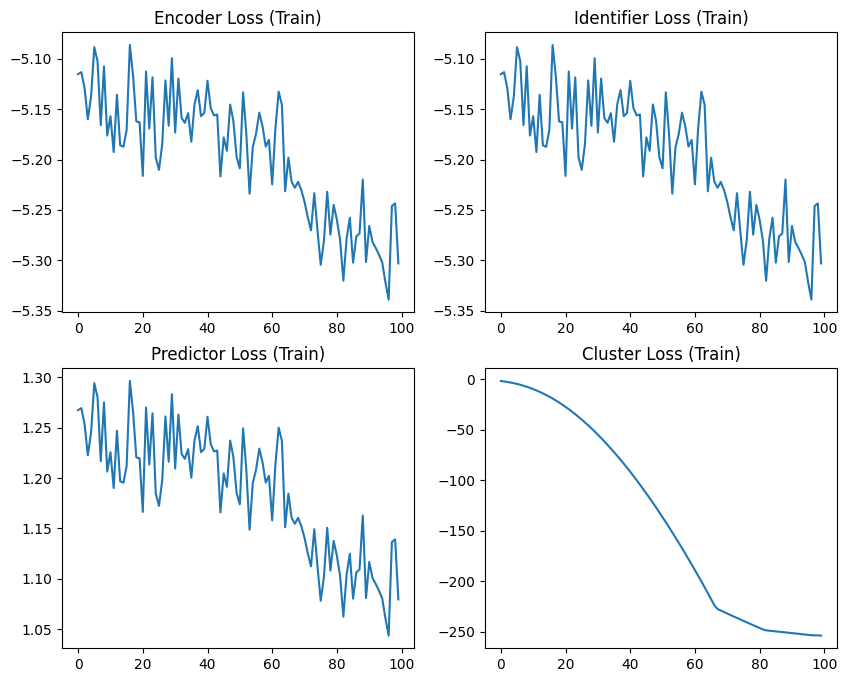

In [46]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(loss_mat[:, 0, 0])
plt.title('Encoder Loss (Train)')
plt.subplot(2, 2, 2)
plt.plot(loss_mat[:, 1, 0])
plt.title('Identifier Loss (Train)')
plt.subplot(2, 2, 3)
plt.plot(loss_mat[:, 2, 0])
plt.title('Predictor Loss (Train)')
plt.subplot(2, 2, 4)
plt.plot(loss_mat[:, 3, 0])
plt.title('Cluster Loss (Train)')
plt.show()

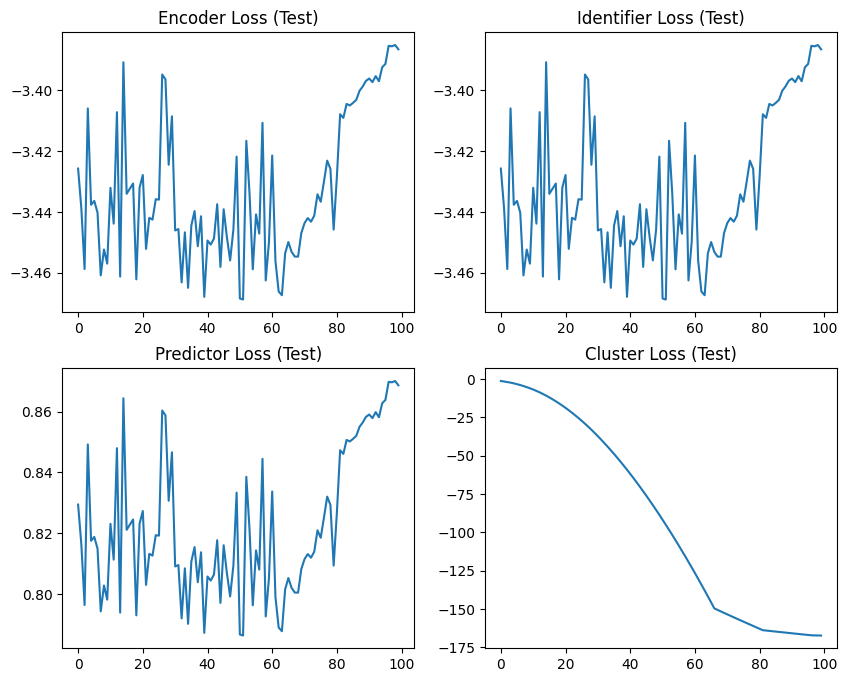

In [47]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(loss_mat[:, 0, 1])
plt.title('Encoder Loss (Test)')
plt.subplot(2, 2, 2)
plt.plot(loss_mat[:, 1, 1])
plt.title('Identifier Loss (Test)')
plt.subplot(2, 2, 3)
plt.plot(loss_mat[:, 2, 1])
plt.title('Predictor Loss (Test)')
plt.subplot(2, 2, 4)
plt.plot(loss_mat[:, 3, 1])
plt.title('Cluster Loss (Test)')
plt.show()

## Evaluation

In [48]:
def get_test_results(model, test_loader):
    real, preds = [], []
    with torch.no_grad():
        for _, (x, y) in enumerate(test_loader):
            y_pred, _ = model.forward_pass(x)
            preds.extend(list(y_pred.cpu().detach().numpy()))
            real.extend(list(y.cpu().detach().numpy()))
    return real, preds


def calc_metrics(real, preds):
    auc = roc_auc_score(real, preds, average=None)

    labels_true, labels_pred = np.argmax(
        real, axis=1), np.argmax(preds, axis=1)

    # Compute F1
    f1 = f1_score(labels_true, labels_pred, average=None)

    # Compute Recall
    rec = recall_score(labels_true, labels_pred, average=None)

    # Compute NMI
    nmi = normalized_mutual_info_score(labels_true, labels_pred)

    return auc, f1, rec, nmi

In [50]:
real, preds = get_test_results(model, test_loader)

auc, f1, rec, nmi = calc_metrics(real, preds)

print(f'AUCROC: \t{auc.mean():.5f}, \t{auc}')
print(f'F1-score: \t{f1.mean():.5f}, \t{f1}')
print(f'Recall: \t{rec.mean():.5f}, \t{rec}')
print(f'NMI: \t\t{nmi:.5f}')

AUCROC: 	0.76587, 	[0.88239138 0.76488279 0.76063422 0.65557101]
F1-score: 	0.34136, 	[0.11560694 0.46281975 0.78700871 0.        ]
Recall: 	0.45203, 	[0.5        0.59662577 0.71148936 0.        ]
NMI: 		0.11257


## Results

All the ablation studies are evaluated on AUC, F1-score, Recall, and NMI and 10 seeds (the same as the paper).

Our model achieves the following performance on :

Ablations in the paper:
| | CAMELOT | Without $loss_{dist}$ | Without $loss_{clus}$ | Without $loss_{dist}, loss_{clus}$ | Without Attention |
|:---:|:---:|:---:|:---:|:---:|:---:|
| AUC | 0.771 (±0.023) | 0.773 (±0.010) | 0.765 (±0.017) | 0.768 (±0.013) | 0.748 (±0.081) |
| F1-score | 0.318 (±0.021) | 0.317 (±0.016) | 0.317 (±0.027) | 0.323 (±0.014) | 0.322 (±0.039) |
| Recall | 0.353 (±0.006) | 0.353 (±0.006) | 0.347 (±0.009) | 0.355 (±0.010) | 0.385 (±0.066) |
| NMI | 0.109 (±0.010) | 0.106 (±0.010) | 0.104 (±0.017) | 0.107 (±0.012) | 0.105 (±0.039) |

Ablations proposed:
| | CAMELOT-GMM | CAMELOT-GRU | CAMELOT-Denoising |
|:---:|:---:|:---:|:---:|
| AUC | 0.768 (± 0.019) | 0.764 (± 0.019) | 0.764 (± 0.009) |
| F1-score | 0.324 (± 0.012) | 0.323 (± 0.010) | 0.320 (± 0.013) |
| Recall | 0.353 (± 0.006) | 0.364 (± 0.022) | 0.362 (± 0.036) |
| NMI | 0.107 (± 0.006) | 0.101 (± 0.010) | 0.103 (± 0.011) |

Or you can test them yourself by running:

In [51]:
from evaluation_utils import prepare_dataloader, train_loop, get_test_results, calc_metrics
from CAMELOT import CamelotModel
from variants_paper import CAMELOT_FF
from variants_ours import CAMELOT_GMM, CAMELOT_GRU, CAMELOT_Denoising

In [53]:
metrics = ['AUC', 'F1 score', 'Recall', 'NMI']
seeds = [1001, 1012, 1134, 2475, 6138, 7415, 1663, 7205, 9253, 1782]

results = np.zeros((len(seeds), 4))
for index, SEED in enumerate(seeds):
    torch.random.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prepare_dataloader(SEED)

    """
    Change the model (name or hyperparameters) for each ablation study:
        - Papers's Ablations:
            1. no change
            2. CAMELOT with alpha=0
            3. CMAELOT with beta=0
            4. CMAELOT with alpha=beta=0
            5. CAMELOT_FF
        - Our Ablations:
            1. CAMELOT_GMM
            2. CAMELOT_GRU
            3. CAMELOT_Denoising
    """
    model = CamelotModel(input_shape=(train_dataset.x.shape[1], train_dataset.x.shape[2]), seed=SEED, num_clusters=10, latent_dim=64)
    
    model = train_loop(model, train_dataset, val_dataset, train_loader, val_loader, SEED=SEED)

    real, preds = get_test_results(model, test_loader)

    auc, f1, rec, nmi = calc_metrics(real, preds)

    print(f'AUCROC: \t{auc.mean():.5f}, \t{auc}')
    print(f'F1-score: \t{f1.mean():.5f}, \t{f1}')
    print(f'Recall: \t{rec.mean():.5f}, \t{rec}')
    print(f'NMI: \t\t{nmi:.5f}')
    
    results[index, 0] = auc.mean()
    results[index, 1] = f1.mean()
    results[index, 2] = rec.mean()
    results[index, 3] = nmi


MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:15<00:15,  3.14it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:13<00:13,  3.59it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


AUCROC: 	0.76683, 	[0.87269683 0.7708899  0.74505894 0.67865596]
F1-score: 	0.30048, 	[0.         0.48450704 0.7174298  0.        ]
Recall: 	0.34870, 	[0.         0.79141104 0.60340426 0.        ]
NMI: 		0.09161

MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:15<00:15,  3.18it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:13<00:13,  3.65it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


AUCROC: 	0.76754, 	[0.85862463 0.76405341 0.75213144 0.69534151]
F1-score: 	0.31640, 	[0.         0.50308642 0.76250302 0.        ]
Recall: 	0.35537, 	[0.         0.75       0.67148936 0.        ]
NMI: 		0.10155

MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:15<00:15,  3.19it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:13<00:13,  3.65it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


AUCROC: 	0.78333, 	[0.87659262 0.79326239 0.76297465 0.70048739]
F1-score: 	0.33242, 	[0.         0.52199413 0.80767474 0.        ]
Recall: 	0.35871, 	[0.         0.68251534 0.75234043 0.        ]
NMI: 		0.11400

MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:15<00:15,  3.18it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:13<00:13,  3.67it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


AUCROC: 	0.77625, 	[0.88773277 0.79417071 0.7712961  0.65181045]
F1-score: 	0.32867, 	[0.         0.51988796 0.79478827 0.        ]
Recall: 	0.35962, 	[0.         0.71165644 0.72680851 0.        ]
NMI: 		0.11228

MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:16<00:16,  3.08it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:14<00:14,  3.53it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


AUCROC: 	0.75619, 	[0.90212349 0.74757215 0.70609716 0.6689531 ]
F1-score: 	0.32557, 	[0.         0.49668475 0.80560579 0.        ]
Recall: 	0.34755, 	[0.         0.63190184 0.75829787 0.        ]
NMI: 		0.09718

MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:15<00:15,  3.16it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:13<00:13,  3.65it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


AUCROC: 	0.71470, 	[0.83401666 0.72289778 0.71007684 0.59180137]
F1-score: 	0.30788, 	[0.         0.49469624 0.73684211 0.        ]
Recall: 	0.35383, 	[0.         0.78680982 0.62851064 0.        ]
NMI: 		0.09916

MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:16<00:16,  3.06it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:14<00:14,  3.49it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


AUCROC: 	0.78473, 	[0.89735381 0.77943882 0.77519283 0.68692302]
F1-score: 	0.31598, 	[0.         0.51901781 0.74488268 0.        ]
Recall: 	0.36540, 	[0.         0.82668712 0.63489362 0.        ]
NMI: 		0.12399

MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:15<00:15,  3.17it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:13<00:13,  3.66it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


AUCROC: 	0.77391, 	[0.89977132 0.77884275 0.75453212 0.66248079]
F1-score: 	0.33173, 	[0.         0.50849591 0.81842457 0.        ]
Recall: 	0.35055, 	[0.         0.6196319  0.78255319 0.        ]
NMI: 		0.11368

MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:15<00:15,  3.17it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:13<00:13,  3.59it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


AUCROC: 	0.77031, 	[0.90780791 0.78050499 0.759238   0.63370032]
F1-score: 	0.32477, 	[0.         0.50648618 0.79257541 0.        ]
Recall: 	0.35386, 	[0.         0.68865031 0.72680851 0.        ]
NMI: 		0.10524

MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


 50%|█████     | 50/100 [00:15<00:15,  3.15it/s]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [00:13<00:13,  3.58it/s]


Identifier initialization done!


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

AUCROC: 	0.77695, 	[0.89032996 0.78345724 0.75686905 0.67715005]
F1-score: 	0.33442, 	[0.         0.5076412  0.83005679 0.        ]
Recall: 	0.34860, 	[0.         0.58588957 0.80851064 0.        ]
NMI: 		0.10768


In [54]:
# take average and std
for m, u, std in zip(metrics, results.mean(axis=0), results.std(axis=0)):
    print(f'{m}: {u:.3f} ({std:.3f})')

AUC: 0.767 (0.019)
F1 score: 0.322 (0.011)
Recall: 0.354 (0.005)
NMI: 0.107 (0.009)


## References

[1] Henrique Aguiar, Mauro Santos, Peter Watkinson, and Tingting Zhu. 2022. Learning of cluster-based feature importance for electronic health record time-series. In Proceedings of the 39th International Conference on Machine Learning, volume 162 of Proceedings of Machine Learning Research, pages 161–179. PMLR.

[2] Johnson, A., Bulgarelli, L., Pollard, T., Celi, L. A., Mark, R., & Horng, S. (2021). MIMIC-IV-ED (version 1.0). PhysioNet. https://doi.org/10.13026/77z6-9w59.

[3] Johnson, Alistair, et al. "MIMIC-IV" (version 1.0). PhysioNet (2021), https://doi.org/10.13026/s6n6-xd98.

[4] L. Amaral L. Glass J. Hausdorff P. C. Ivanov R. Mark J. E. Mietus G. B. Moody C. K. Peng Goldberger, A. and H. E. Stanley. 2000. Physiobank, physiotoolkit, and physionet: Components of a new research resource for complex physiologic signals. Circulation [Online], 101(23):e150–e220.